In [37]:
# !pip install -U sentence-transformers
#!pip install gensim

Imports

In [38]:
import numpy as np
import pandas as pd
import pickle
from sentence_transformers import SentenceTransformer
import time
import math
import re
import gensim

Load Data

In [39]:
df = pd.read_csv('datasets/FEVER/Train.csv')
df.rename(columns={'claim': 'sentence'}, inplace=True)
df = df.sample(n=df.shape[0], random_state=2000, replace=False).reset_index(drop=True)
df_train, df_dev = np.split(df, [int(.9*len(df))])

df_test = pd.read_csv('datasets/FEVER/Test.csv')
df_test.rename(columns={'claim': 'sentence'}, inplace=True)
df_test = df_test.sample(n=df_test.shape[0], random_state=2000, replace=False).reset_index(drop=True)

In [40]:
print(df_train.shape)
print(df_dev.shape)
print(df_test.shape)

(4500, 5)
(500, 5)
(1999, 5)


Generate GloVe embeddings

In [41]:
def load_glove_embeddings(file_path):
    word_vectors = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            word_vectors[word] = coefs
    return word_vectors

# Replace 'glove.6B.100d.txt' with the appropriate file name for the dimension you downloaded
glove_file_path = 'glove.6B.50d.txt'
glove_embeddings = load_glove_embeddings(glove_file_path)


def sentence_embedding(sentence, embeddings):
    words = sentence.lower().split()
    embedding = np.mean([embeddings[word] for word in words if word in embeddings], axis=0)
    return embedding


In [42]:
X_train = []

for sentence in df_train.sentence:
    sentence_vec = sentence_embedding(sentence, glove_embeddings)
    X_train.append(sentence_vec)

y_train = df_train["label"]

In [43]:
X_test = []

for sentence in df_test.sentence:
    sentence_vec = sentence_embedding(sentence, glove_embeddings)
    X_test.append(sentence_vec)

In [44]:
X_dev = []

for sentence in df_dev.sentence:
    sentence_vec = sentence_embedding(sentence, glove_embeddings)
    X_dev.append(sentence_vec)

y_dev = df_dev["label"]

In [45]:
# save the embedding results
pickle.dump(X_train, open("datasets/FEVER/embeddings/GloVe/train_embeddings_originals.p","wb" ))
pickle.dump(X_dev, open("datasets/FEVER/embeddings/GloVe/dev_embeddings_originals.p", "wb"))
pickle.dump(X_test, open("datasets/FEVER/embeddings/GloVe/test_embeddings_originals.p", "wb"))

# save the labels
pickle.dump(y_train, open("datasets/FEVER/embeddings/GloVe/train_labels_originals.p", "wb"))
pickle.dump(y_dev, open("datasets/FEVER/embeddings/GloVe/dev_labels_originals.p", "wb"))

In [46]:
# load the embeddings
X_train = pickle.load(open("datasets/FEVER/embeddings/GloVe/train_embeddings_originals.p", "rb"))
X_dev = pickle.load(open("datasets/FEVER/embeddings/GloVe/dev_embeddings_originals.p", "rb"))
X_test = pickle.load(open("datasets/FEVER/embeddings/GloVe/test_embeddings_originals.p", "rb"))

# load the labels
y_train = pickle.load(open("datasets/FEVER/embeddings/GloVe/train_labels_originals.p", "rb"))
y_dev = pickle.load(open("datasets/FEVER/embeddings/GloVe/dev_labels_originals.p", "rb"))

Calculate TF-IDF Score

In [47]:
#Tokenize each senetence
df_train["list_of_words"] = 0

for i in range(len(df_train['sentence'])):
    sentence = df["sentence"][i].lower()
    sentence = re.sub(r'[^\w\s]', '', sentence)
 
    result = sentence.split()
    df_train["list_of_words"][i] = result
    
df_train


C:\Users\HP\AppData\Local\Temp\ipykernel_34928\350617880.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["list_of_words"][i] = result


,id,verifiable,label,sentence,evidence,list_of_words
0,202454,VERIFIABLE,REFUTES,Tinker Tailor Soldier Spy is a music video.,"[[[238546, 240543, 'Tinker_Tailor_Soldier_Spy_...","[tinker, tailor, soldier, spy, is, a, music, v..."
1,124736,VERIFIABLE,SUPPORTS,Exercise temporarily speeds up the heart rate.,"[[[146323, 161284, 'Heart', 19]]]","[exercise, temporarily, speeds, up, the, heart..."
2,103511,VERIFIABLE,REFUTES,The Faroe Islands are no longer part of a king...,"[[[121508, 135783, 'Faroe_Islands', 1]], [[121...","[the, faroe, islands, are, no, longer, part, o..."
3,99495,VERIFIABLE,SUPPORTS,The Prowler is a non-factual character.,"[[[117143, 131033, 'Prowler_-LRB-comics-RRB-',...","[the, prowler, is, a, nonfactual, character]"
4,57100,NOT VERIFIABLE,NOT ENOUGH INFO,Kelly Preston starred in Batman.,"[[[77331, None, None, None]]]","[kelly, preston, starred, in, batman]"
...,...,...,...,...,...,...
4495,58397,NOT VERIFIABLE,NOT ENOUGH INFO,Connie Nielsen played a bit part on The Follow...,"[[[74761, None, None, None]]]","[connie, nielsen, played, a, bit, part, on, th..."
4496,159711,VERIFIABLE,SUPPORTS,Edgar Wright is a writer of screenplays.,"[[[184149, 196103, 'Edgar_Wright', 0]]]","[edgar, wright, is, a, writer, of, screenplays]"
4497,167984,VERIFIABLE,SUPPORTS,Don Bradman was a Test player.,"[[[193406, 203923, 'Don_Bradman', 1], [193406,...","[don, bradman, was, a, test, player]"
4498,179348,NOT VERIFIABLE,NOT ENOUGH INFO,Osamu Tezuka's mother had to erase pages in hi...,"[[[208083, None, None, None]]]","[osamu, tezukas, mother, had, to, erase, pages..."


In [48]:
def create_tf_matrix(sentences):
    tf_matrix = []
    for list in sentences:
        tf_table = []
        # Determining frequency of words in the sentence
        word_freq = {}
        for word in list:
            word_freq[word] = (word_freq[word] + 1) if word in  word_freq else 1
        # Calculating tf of the words in the sentence
        for word in list:
            tf_table.append((word, math.log10(word_freq[word] + 1)))
        tf_matrix.append(tf_table)
    return tf_matrix

In [49]:
def create_idf_matrix(sentences):

    idf_matrix = []

    documents_count = len(sentences)
    total_words_corpus = []

    # Getting words in the sentence
    for list in sentences:
        total_words_corpus.append(list)

    # Determining word count table with the count of sentences which contains the word.
    word_in_docs = {}
    for list in sentences:
        for word in list:
            word_in_docs[word] = (word_in_docs[word] + 1) if word in word_in_docs else 1

    # Determining idf of the words in the sentence.
    for list in sentences:
        idf_table = []
        for word in list:
            idf_table.append((word, math.log10(documents_count / float(word_in_docs[word]))))

        idf_matrix.append(idf_table)

    return idf_matrix

In [50]:
def create_tf_idf_matrix(tf_matrix, idf_matrix):

    tf_idf_matrix = []

    for i in range(len(tf_matrix)):
        tf_idf_table = []
        tf_of_sentence_words = tf_matrix[i]
        idf_of_sentence_words = idf_matrix[i]

        for word in range(len(tf_of_sentence_words)):
            word_tf, tf_value = tf_of_sentence_words[word]
            word_idf, idf_value = idf_of_sentence_words[word]
            tf_idf_table.append((word_tf, tf_value * idf_value))

        tf_idf_matrix.append(tf_idf_table)

    return tf_idf_matrix

In [51]:
tf_matrix = create_tf_matrix(df_train["list_of_words"])
idf_matrix = create_idf_matrix(df_train["list_of_words"])

tf_idf_matrix = create_tf_idf_matrix(tf_matrix, idf_matrix)

In [52]:
def calculate_sentence_scores(tf_idf_matrix, df_train):
    df_train["tf_idf_score"] = 0
    for sentence in range(len(tf_idf_matrix)):
        sum_of_tf_idf = 0
        len_of_sentence = len(tf_idf_matrix[sentence])
        for i in range(len_of_sentence):
            word, value = tf_idf_matrix[sentence][i]
            sum_of_tf_idf += value
        df_train["tf_idf_score"][sentence] = sum_of_tf_idf/len_of_sentence

    return df_train

In [53]:
df_train = calculate_sentence_scores(tf_idf_matrix, df_train)

C:\Users\HP\AppData\Local\Temp\ipykernel_34928\1346757543.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["tf_idf_score"][sentence] = sum_of_tf_idf/len_of_sentence


Cluster Embeddings on Similarity and Dimensionality Reduction

In [54]:
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity

In [55]:
similarity_threshold = 0.65

embeddings = []
y_train_reduced = []

for i in range(len(X_train)):
    flag = 0
    for j in range(i+1, len(X_train)):
        sim = cosine_similarity(X_train[i], X_train[j])
        if sim >= similarity_threshold:
            if tf_idf_matrix[i] >= tf_idf_matrix[j] and flag == 0:
                embeddings.append(X_train[i])
                y_train_reduced.append(y_train[i])
                flag = 1
            elif tf_idf_matrix[i] < tf_idf_matrix[j] and flag == 0:
                embeddings.append(X_train[j])
                y_train_reduced.append(y_train[j])


In [56]:
X_train_reduced = np.array(embeddings)
y_train_reduced = np.array(y_train_reduced)

***Classification***

In [57]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

SVM

In [58]:
baseline_results = {}
def svm_classification(baseline_results, X_train, y_train, X_dev, y_dev, kernel="rbf"):
      
    beg = time.time()  
    clf = SVC(kernel=kernel)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_dev)
    end = time.time()
    baseline_results[f'SVM-{kernel}'] = classification_report(y_dev, y_pred, output_dict=True)
    baseline_results[f'SVM-{kernel}']['infer_time'] = end-beg

    print(f"SVM with kernel: {kernel}", end='\t')
    print(clf.score(X_dev, y_dev))

In [59]:
svm_classification(baseline_results, X_train, y_train, X_dev, y_dev)

SVM with kernel: rbf	0.438


MLP

In [60]:
def mlp_classification(baseline_results, X_train, y_train, X_dev, y_dev, layers=[200, 100]):
    for layer in layers:
        beg = time.time()
        clf = MLPClassifier(hidden_layer_sizes=layer, max_iter=3000)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        end = time.time()
        baseline_results[f'MLP-{layer}'] = classification_report(y_dev, y_pred, output_dict=True)
        baseline_results[f'MLP-{layer}']['infer_time'] = end-beg
        
        print(f"MLP with layers: {layer}", end='\t')
        print(clf.score(X_dev, y_dev))

In [61]:
mlp_classification(baseline_results, X_train, y_train, X_dev, y_dev)

MLP with layers: 200	0.394
MLP with layers: 100	0.4


Random Forest

In [62]:
def random_forest_classification(baseline_results, X_train, y_train, X_dev, y_dev, n_estimators=100):
        
    beg = time.time()
    clf = RandomForestClassifier(n_estimators=n_estimators)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_dev)
    end = time.time()
    baseline_results[f'RandomForest-{n_estimators}'] = classification_report(y_dev, y_pred, output_dict=True)
    baseline_results[f'RandomForest-{n_estimators}']['infer_time'] = end-beg
        
    print(f"Random Forest with n_estimators: {n_estimators}", end='\t')
    print(clf.score(X_dev, y_dev))

In [63]:
random_forest_classification(baseline_results, X_train, y_train, X_dev, y_dev)

Random Forest with n_estimators: 100	0.416


KNN

In [64]:
def knn_classification(baseline_results, X_train, y_train, X_dev, y_dev, n_neighbors=50):

    beg = time.time()
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_dev)
    end = time.time()
    baseline_results[f'KNN-{n_neighbors}'] = classification_report(y_dev, y_pred, output_dict=True)
    baseline_results[f'KNN-{n_neighbors}']['infer_time'] = end-beg

    print(f"KNN with n_neighbors: {n_neighbors}", end='\t')
    print(clf.score(X_dev, y_dev))

In [65]:
knn_classification(baseline_results, X_train, y_train, X_dev, y_dev)

KNN with n_neighbors: 50	0.396


In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
# plot the best results for each classifier


def plot_results(baseline_results, metric, threshold=-1, figsize=(10, 5), title='Baseline Results'):
    plt.rcParams['figure.dpi'] = 300
    sorted_results = sorted([(k, v['macro avg'][metric]) for k, v in baseline_results.items()], key=lambda x: x[1], reverse=True)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(metric)
    plt.ylabel("Classifier")
    sns.barplot(x=[x[1] for x in sorted_results if x[1] > threshold], y=[x[0] for x in sorted_results if x[1] > threshold]) 
    plt.xlim(0, min(max([x[1] for x in sorted_results])+0.07, 1))
    
    # put the scores on the bars
    for i, v in enumerate([x[1] for x in sorted_results]):
        if v > threshold:
            # set fonr size
            plt.text(v, i + .26, f'{v:.3f}', color='black', rotation=-90, fontsize=8)

def plot_sizes(sizes, title, xlabel, figsize=(10, 5), is_ratio=False):
    # set dpi
    plt.rcParams['figure.dpi'] = 300
    sorted_sizes = sorted([(k, v) for k, v in sizes.items()], key=lambda x: x[1], reverse=True)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Method")

    if is_ratio:
        sns.barplot(x=[x[1] for x in sorted_sizes], y=[x[0] for x in sorted_sizes])
        plt.xlim(0, max([x[1] for x in sorted_sizes])+10)
        # for i, v in enumerate([x[1] for x in sorted_sizes]):
        #     plt.text(v, i + .25, f'{v:.2f}', color='black')
    else:
        sns.barplot(x=[x[1]/(1024*1024) for x in sorted_sizes], y=[x[0] for x in sorted_sizes])
        plt.xlim(0, 10)
        for i, v in enumerate([x[1] for x in sorted_sizes]):
            plt.text(v/(1024*1024), i + .25, f'{v/(1024*1024):.2f} MB', color='black')


    plt.tight_layout()

def plot_inference_time(inference_times, title, xlabel, figsize=(20, 20)):
    plt.rcParams['figure.dpi'] = 300
    sorted_inference_times = sorted([(k, v['infer_time']) for k, v in inference_times.items()], key=lambda x: x[1], reverse=True)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Classifier")
    # vertical barplot

    sns.barplot(x=[x[1] for x in sorted_inference_times], y=[x[0] for x in sorted_inference_times])

    
    plt.xlim(0, 6)
    for i, v in enumerate([x[1] for x in sorted_inference_times]):
        plt.text(v, i + .25, f'{v:.2f} s', color='black')

    plt.tight_layout()


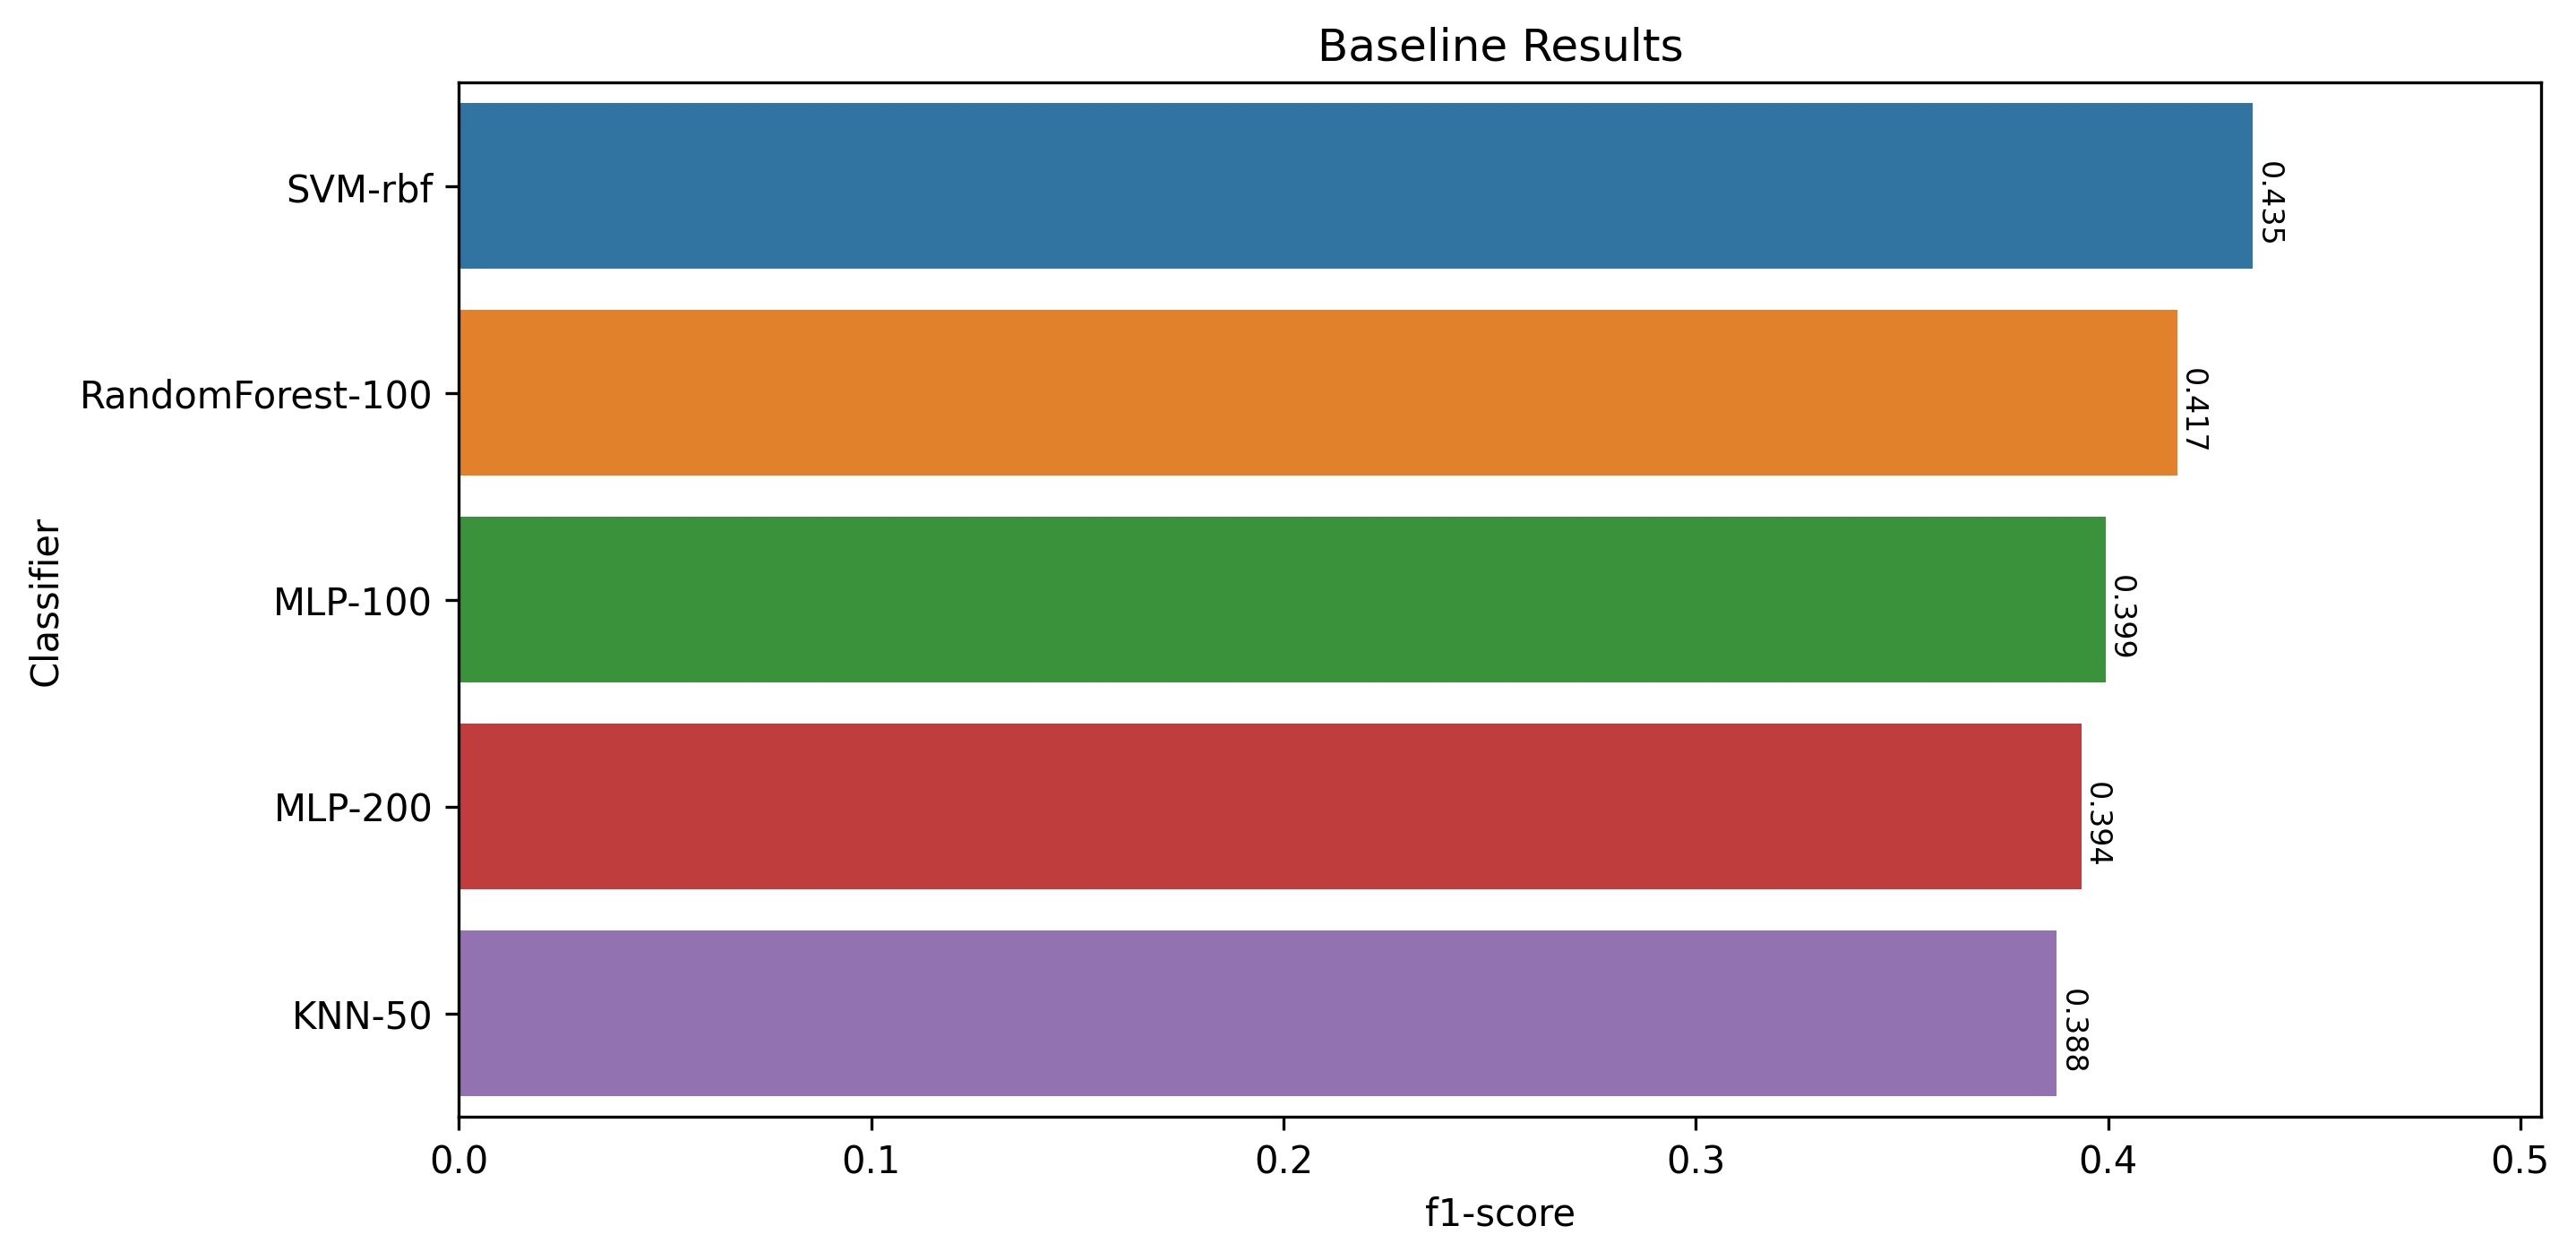

In [68]:
plot_results(baseline_results, 'f1-score')

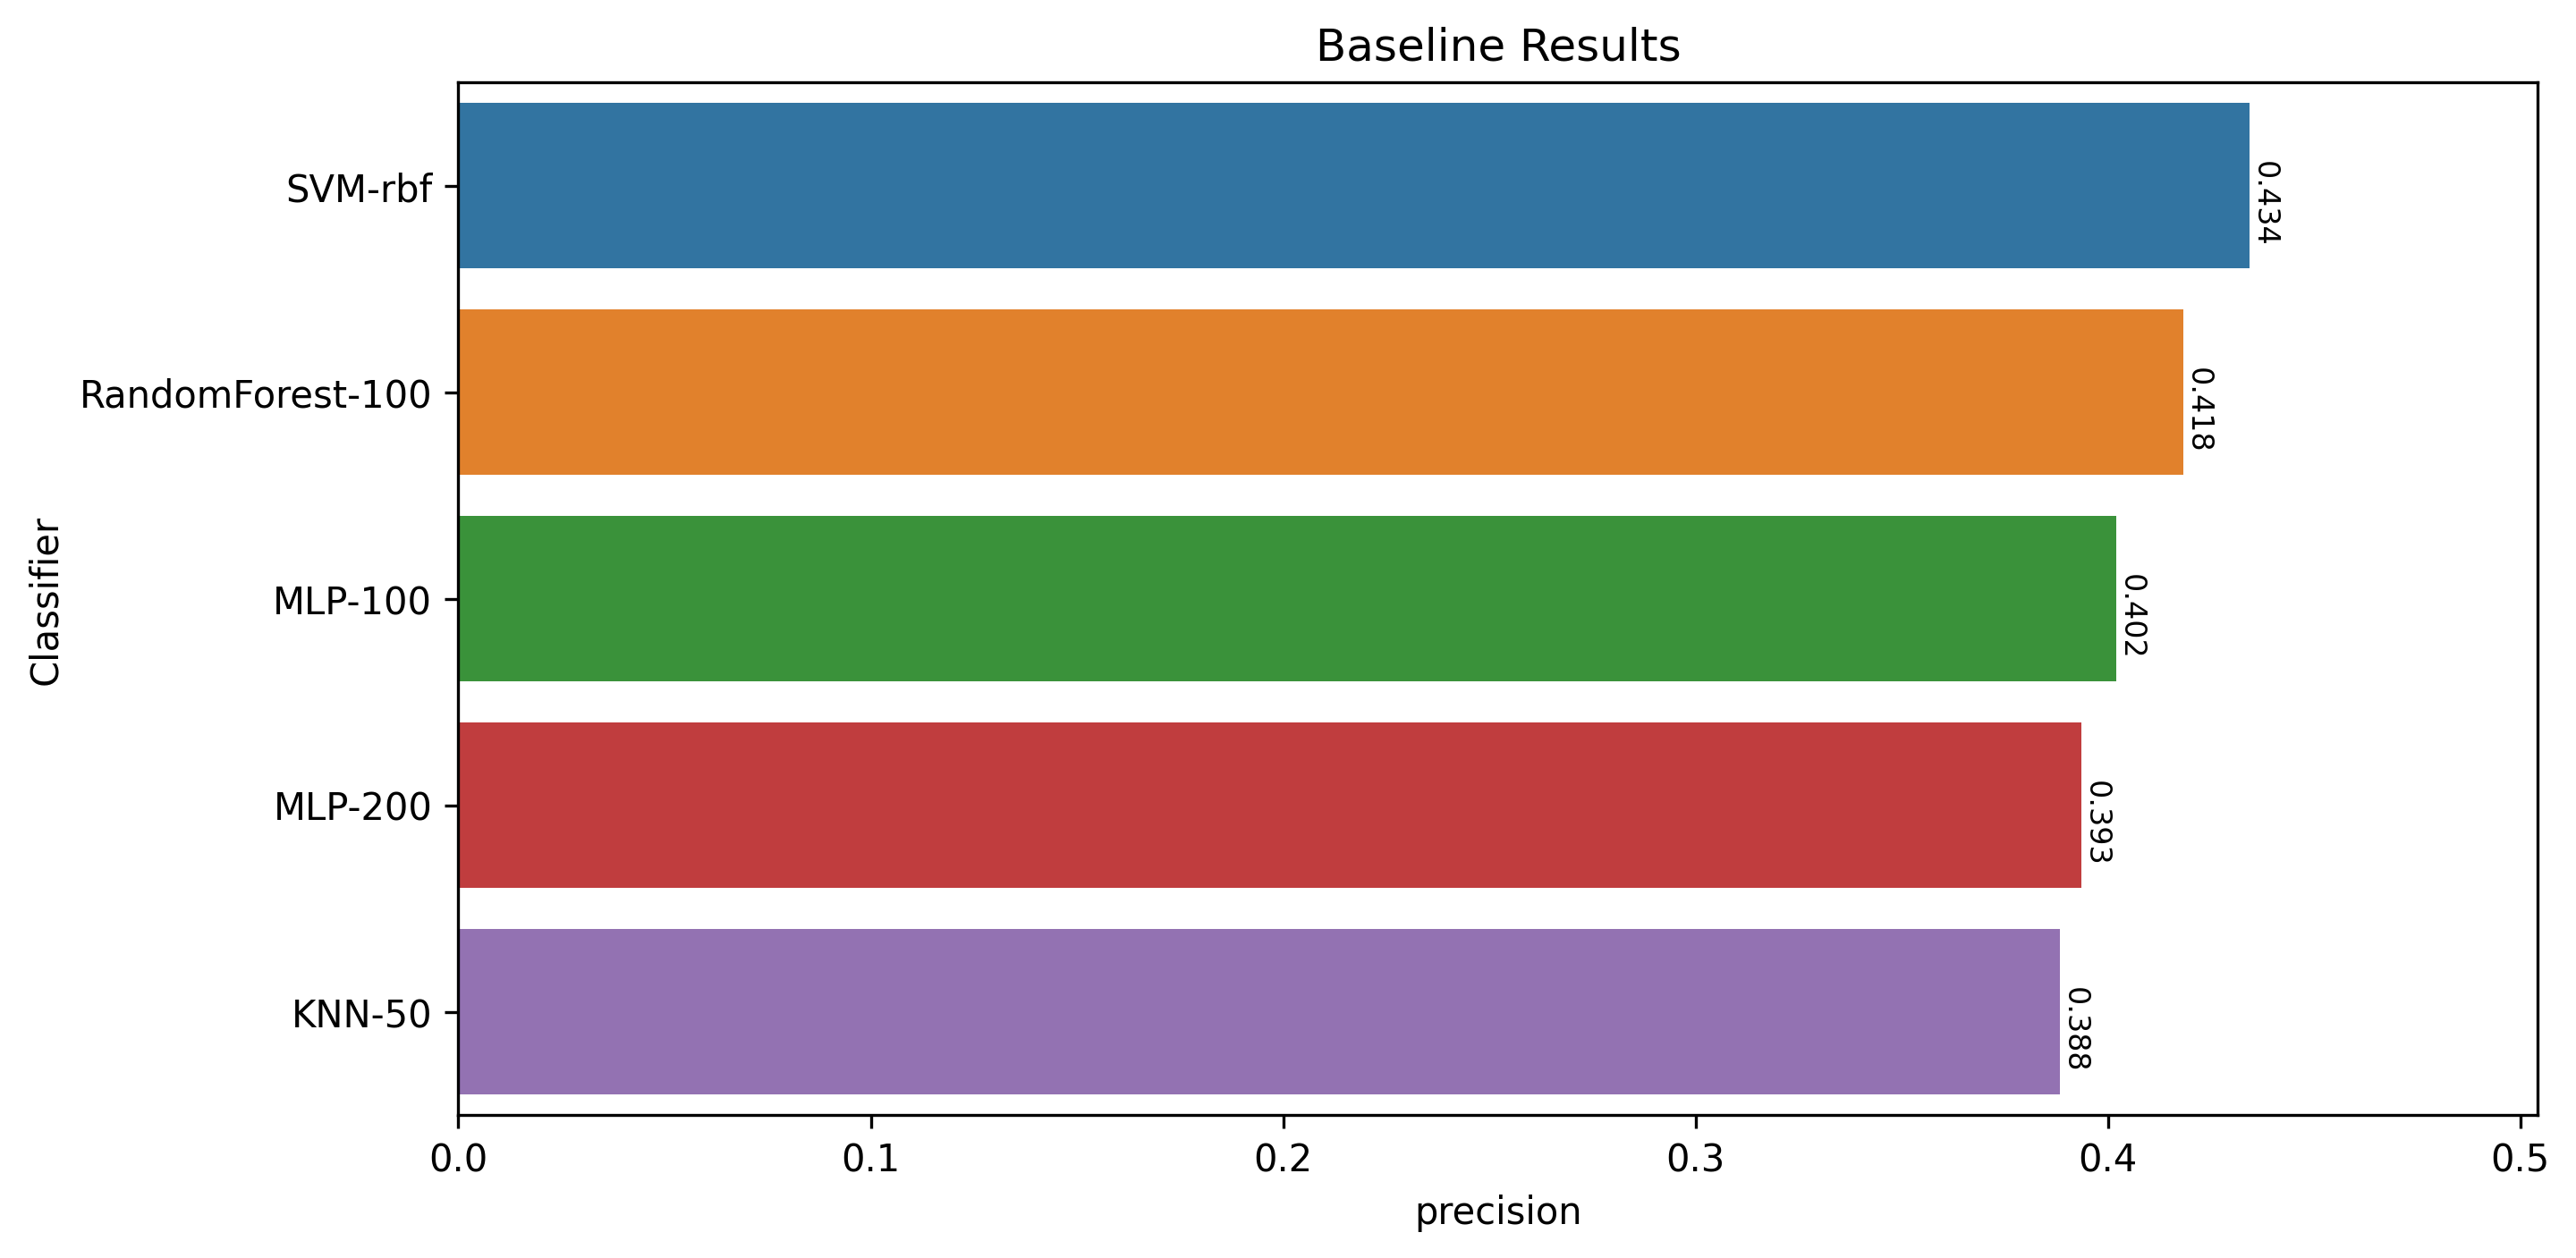

In [69]:
plot_results(baseline_results, 'precision')

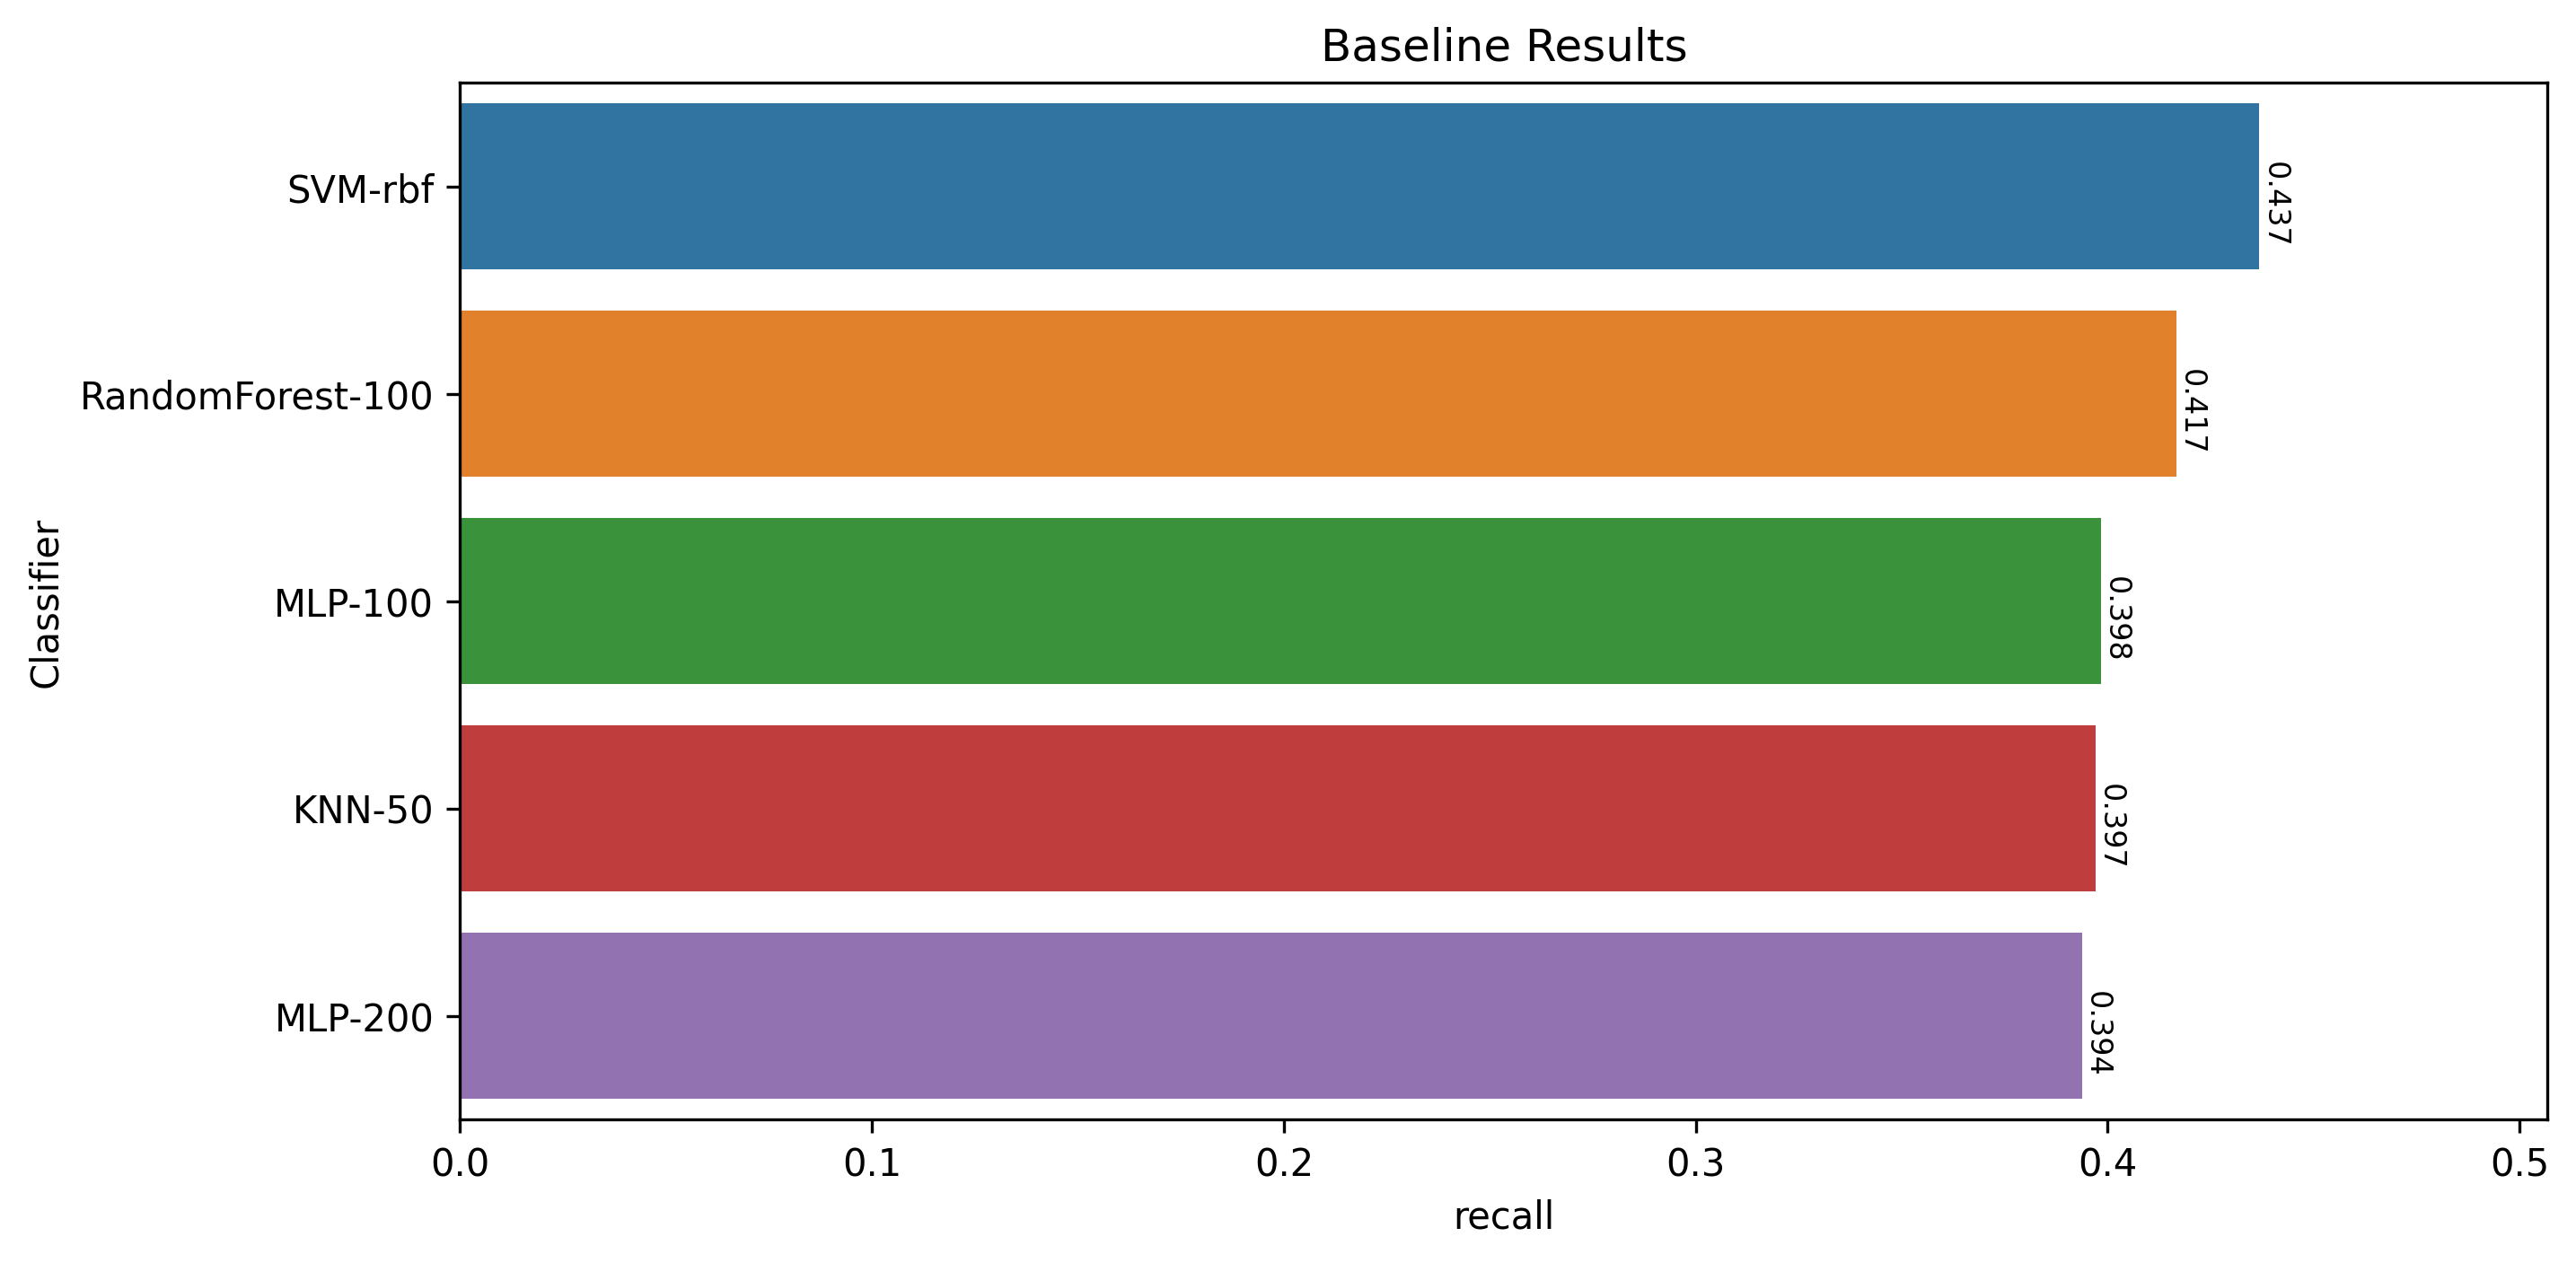

In [70]:
plot_results(baseline_results, 'recall')

In [79]:
plot_inference_time(baseline_results, 'Inference Time', 'Time (s)')

C:\Users\HP\AppData\Local\Temp\ipykernel_34928\2266565711.py:59: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
